In [1]:
import sys

sys.path.append("..")

import pickle as pkl

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from cbdetect_py import (
    CornerType,
    Params,
    boards_from_corners,
    find_corners,
    hessian_response,
)
from ipywidgets import FloatSlider, IntRangeSlider, interact
from pandas.compat import os
from PIL import Image, ImageOps
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

from calibration.benchmark.benchmark import (
    BenchmarkResult,
    benchmark_babelcalib,
    benchmark_simul,
)
from calibration.benchmark.benchmark_result import calc_error
from calibration.data.babelcalib.babelcalib import load_babelcalib
from calibration.data.babelcalib.entry import Entry
from calibration.feature_detector.checkerboard import detect_corners
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.feature_refiner.classifier import get_corner_responses
from calibration.feature_refiner.refine import refine_features_single
from calibration.feature_refiner.visualization import show_refined_corners

%load_ext autoreload
%autoreload 2

In [2]:
with open("../refined_babelcalib_results_None.pkl", "rb") as f:
    results = pkl.load(f)

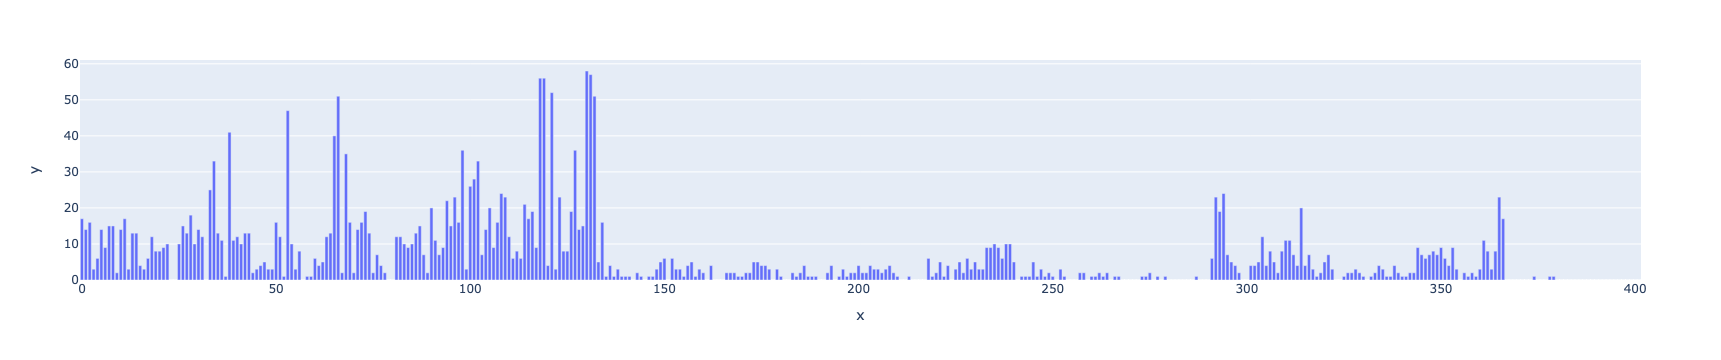

In [3]:
px.bar(y=[(r.new_board_mask == 2).sum() for r in results if r])

In [6]:
results_ = sorted([r for r in results if r is not None], key=lambda r: r.error)
results_ = sorted(
    [r for r in results if r is not None], key=lambda r: (r.new_board_mask == 2).sum()
)

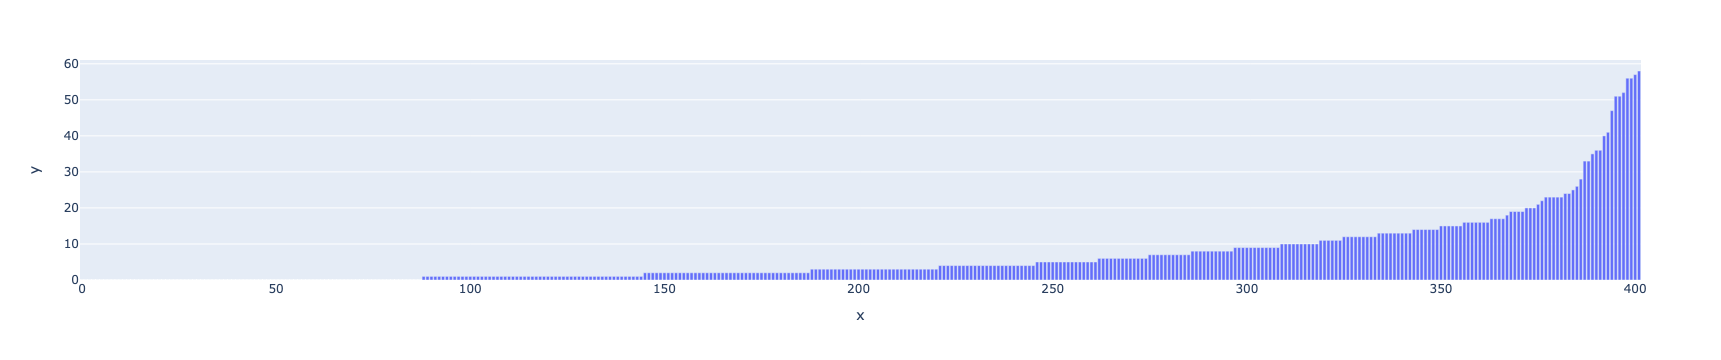

In [7]:
px.bar(y=[(r.new_board_mask == 2).sum() for r in results_])

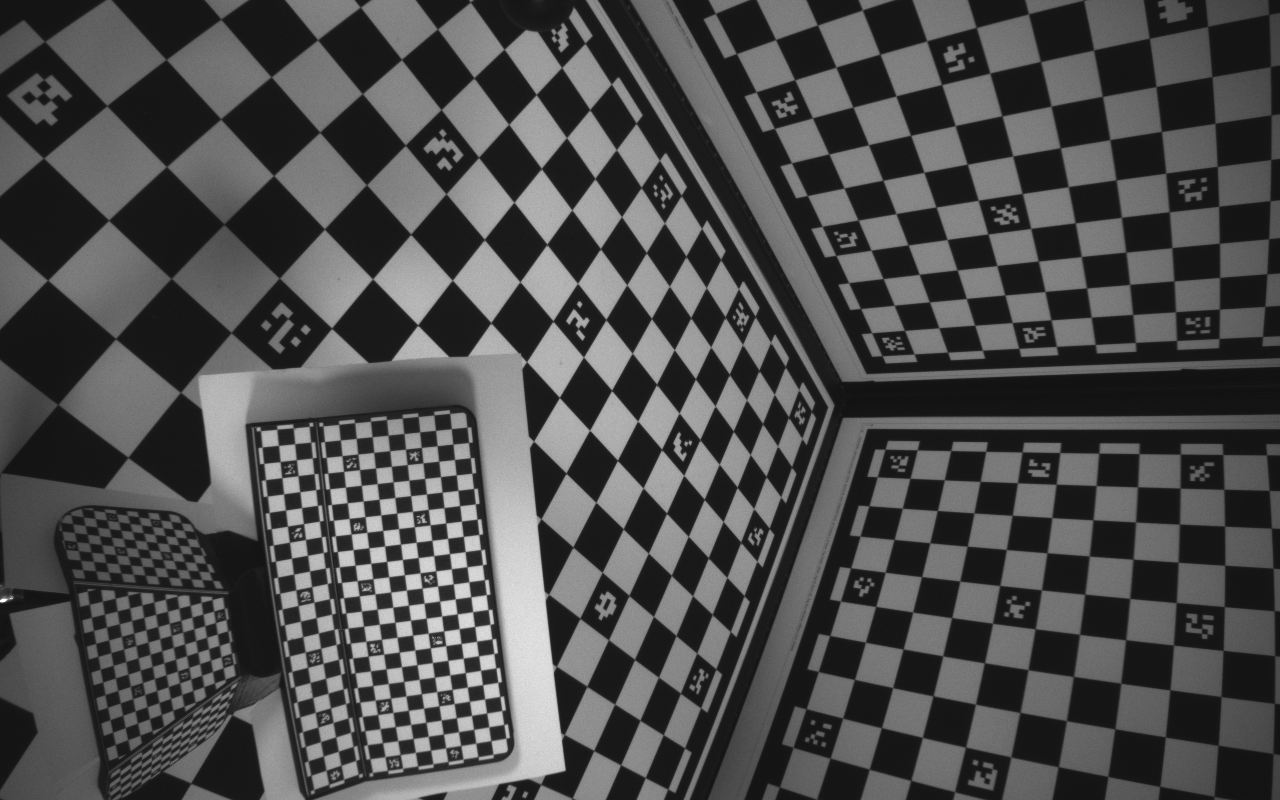

In [8]:
results_[-1].input.image

In [20]:
@interact
def f(i=(0, len(results_))):
    r = results_[i]
    w, h = r.input.image.size

    print(
        f"{i}, error_Optim={r.error}, n_new_corners = {(r.new_board_mask == 2).sum()}"
    )

    show_refined_corners(
        np.array(r.input.image),
        r.refined_features.corners,
        r.refined_features.board,
        r.new_board_mask,
        r.responses,
        # ).update_layout(height=h, width=w, title="Refined").show()
    ).update_layout(
        height=h + 400,
        width=w,
        showlegend=False,
        margin=dict(l=20, r=20, t=20, b=20),
    ).show()
    return
    show_boards(
        np.array(r.input.image),
        r.features.corners,
        r.features.board,
        # r.new_board_mask,
        # r.responses,
    ).update_layout(height=h, width=w, title="Refined").show()
    px.scatter(r.features.board, x=0, y=1, width=w, height=h).show()
    px.scatter(r.refined_features.board, x=0, y=1, width=w, height=h).show()

    # print(r.features.board)
    # print(r.refined_features.board)

    px.imshow(
        hessian_response(np.array(r.input.image)).repeat(2, axis=0).repeat(2, axis=1)
    ).show()
    r_ = BenchmarkResult(r.input, r.features, {"Optimization": r.prediction})
    px.imshow(get_corner_responses(r_)).show()

interactive(children=(IntSlider(value=201, description='i', max=402), Output()), _dom_classes=('widget-interac…

In [ ]:
i=84
r = results_[i]
w, h = r.input.image.size

print(
    f"{i}, error_Optim={r.error}, n_new_corners = {(r.new_board_mask == 2).sum()}"
)

show_refined_corners(
    np.array(r.input.image),
    r.refined_features.corners,
    r.refined_features.board,
    r.new_board_mask,
    r.responses,
    # ).update_layout(height=h, width=w, title="Refined").show()
).update_layout(
    height=h + 400,
    width=w,
    showlegend=False,
    margin=dict(l=20, r=20, t=20, b=20),
).show()
show_boards(
    np.array(r.input.image),
    r.features.corners,
    r.features.board,
    # r.new_board_mask,
    # r.responses,
).update_layout(height=h, width=w, title="Refined").show()
px.scatter(r.features.board, x=0, y=1, width=w, height=h).show()
px.scatter(r.refined_features.board, x=0, y=1, width=w, height=h).show()

# print(r.features.board)
# print(r.refined_features.board)

px.imshow(
    hessian_response(np.array(ImageOps.grayscale(r.input.image))).repeat(2, axis=0).repeat(2, axis=1), width=w, height=h
).show()
r_ = BenchmarkResult(r.input, r.features, {"Optimization": r.prediction})
px.imshow(detect_corners(np.array(ImageOps.grayscale(r.input.image))), width=w, height=h).show()